# Special Cases

This notebook illustrates how the algorithm for fitting the varying coefficient model reduces to normal gradient boosting or gradient descent for least squares regression in case of $x=1$ or $z=1$, respectively.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from vcboost import VCBooster
from sklearn.ensemble import GradientBoostingRegressor

## Case 1: Gradient Boosting

### Generate Data

In [2]:
n = 1000  # sample size for this example

rng = np.random.default_rng(749)  # set up random number generator

# unknown smooth function to approximate
def f(z):
    return 0.01 * z**3 + 0.3* z**2 - 0.2 * z + 4*np.sin(1.2*z)

z = rng.uniform(-10, 10, n)

y = f(z) + rng.normal(0, 3, n)

### Fit models

The `VCBoost` model is used with constant covariate $x$. For comparison the `GradientBoostingRegressor` available in sklearn is fitted to the same data. Both boosting models use the same base learners, e.g. regression trees also available in sklearn. 

In [3]:
# set up and fit vcb model with constant x  (i.e. only an intercept varying with z)
vcb = VCBooster(max_depth=5, learning_rate=0.01, min_samples_leaf=0.05, n_stages=300)
vcb.fit(X=np.ones((n, 1)), Z=z.reshape(-1, 1), y=y)

# set up and fit sklearn gradient boosting regressor with matching params
gbr = GradientBoostingRegressor(max_depth=5, learning_rate=0.01, min_samples_leaf=0.05, n_estimators=300, criterion='mse', init='zero')
gbr.fit(X=z.reshape(-1, 1), y=y)

GradientBoostingRegressor(criterion='mse', init='zero', learning_rate=0.01,
                          max_depth=5, min_samples_leaf=0.05, n_estimators=300)

### Inspect results

As expected, `VCBoost` and `GradientBoostingRegressor` approximations of `f` are very similar.

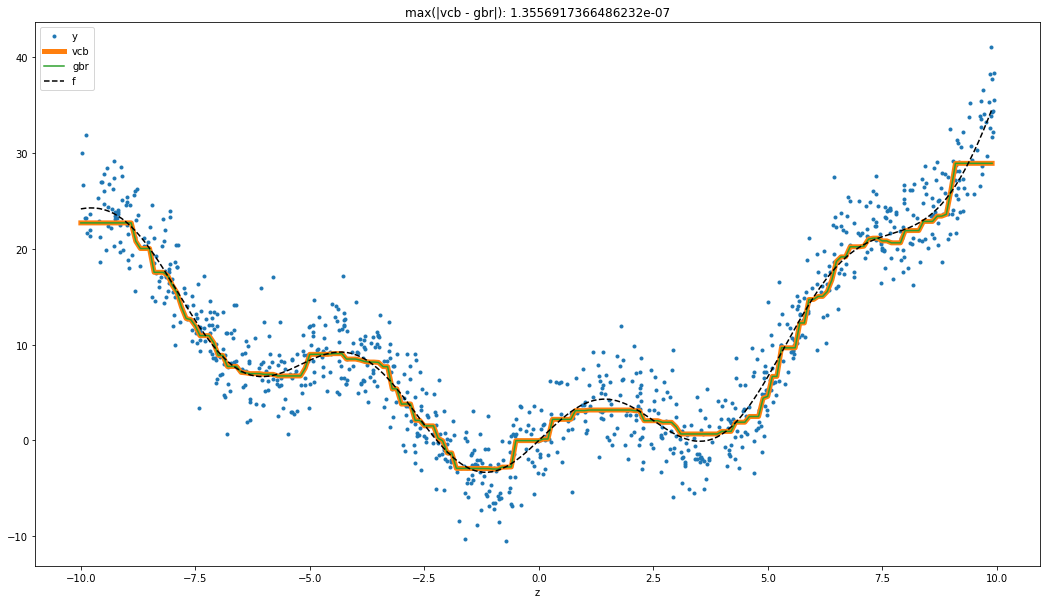

In [4]:
# true function and both models are evaluated for a regular grid
z_grid = np.arange(-10, 10, 0.1)
f_grid = f(z_grid)
vcb_grid = vcb.predict(X=np.ones((len(z_grid), 1)), Z=z_grid.reshape(-1, 1))
gbr_grid = gbr.predict(X=z_grid.reshape(-1, 1))

# visualize data, true function and models
fig, ax = plt.subplots(1, 1, figsize=(18, 10), sharey=True)

ax.plot(z, y, '.', label='y')  # data
ax.plot(z_grid, vcb_grid, linestyle='-', label='vcb', lw=5)  # f estimated by vcb
ax.plot(z_grid, gbr_grid, linestyle = '-', label='gbr')  # f estimated by gbr
ax.plot(z_grid, f_grid, linestyle='--', c='k', label='f')  # true function

# labels and legends
ax.set_title(f'max(|vcb - gbr|): {np.max(np.abs(vcb_grid - gbr_grid))}')
ax.set_xlabel('z')
ax.legend()

## Case 2: Linear Regression

## Generate data

In [5]:
n = 1000  # sample size for this example

rng = np.random.default_rng(184)  # set up random number generator

beta = np.array([7, 1, 0.8])  # coefficients

x = rng.uniform(-2, 2, n)  # single covariate

# data for model y = beta[0] + beta[1]*x + beta[2]*x**2 + noise
X = np.ones((n, 3))
X[:, 1] = x
X[:, 2] = x**2

y =  X @ beta + rng.normal(0, 0.8, n)

### Fit Models

This time the `VCBoost` model is used with constant effect modifier $z$. For comparison the usual least squares estimate of the coefficient vector $\beta$ is also computed.

In [6]:
# set up and fit vcb model, this time passing constant effect modifier z
vcb = VCBooster(n_stages=300)
vcb.fit(X=X, Z=np.ones((n, 1)), y=y)

# also get the usual least squares estimator
beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]

### Inspect results

Figure below shows, that predictions using the `VCBoost`, usual least squares prediction and true expectation of $y$ (also called $f$ here) are very close.

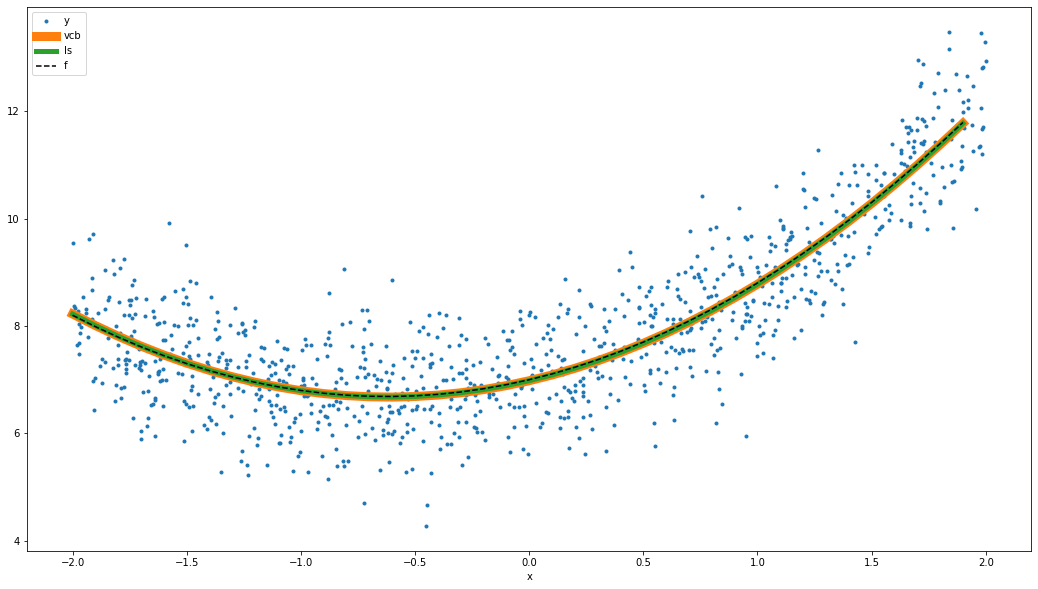

In [7]:
# set up grid of covariate and corresponding design matrix
x_grid = np.arange(-2, 2, 0.1)

X_grid = np.ones((len(x_grid), 3))
X_grid[:, 1] = x_grid
X_grid[:, 2] = x_grid**2

# true expectation of y for grid
f_grid = X_grid @ beta

# vcb predictions for grid
vcb_grid = vcb.predict(X=X_grid, Z=np.ones((len(x_grid), 1)))

# usual least squares prediction for grid
beta_hat_grid = X_grid @ beta_hat

# visualize
fig, ax = plt.subplots(1, 1, figsize=(18, 10), sharey=True)

ax.plot(x, y, '.', label='y')  # data
ax.plot(x_grid, vcb_grid, lw=9, label='vcb')  # vcb fit
ax.plot(x_grid, beta_hat_grid, lw=5, label='ls')  # least squares fit
ax.plot(x_grid, f_grid, '--', c='k', label='f')  # true expectation of y

# labels and legends
ax.set_xlabel('x')
ax.legend()

The next figure shows, that the vcb coefficient estimates converge to the least square estiates.

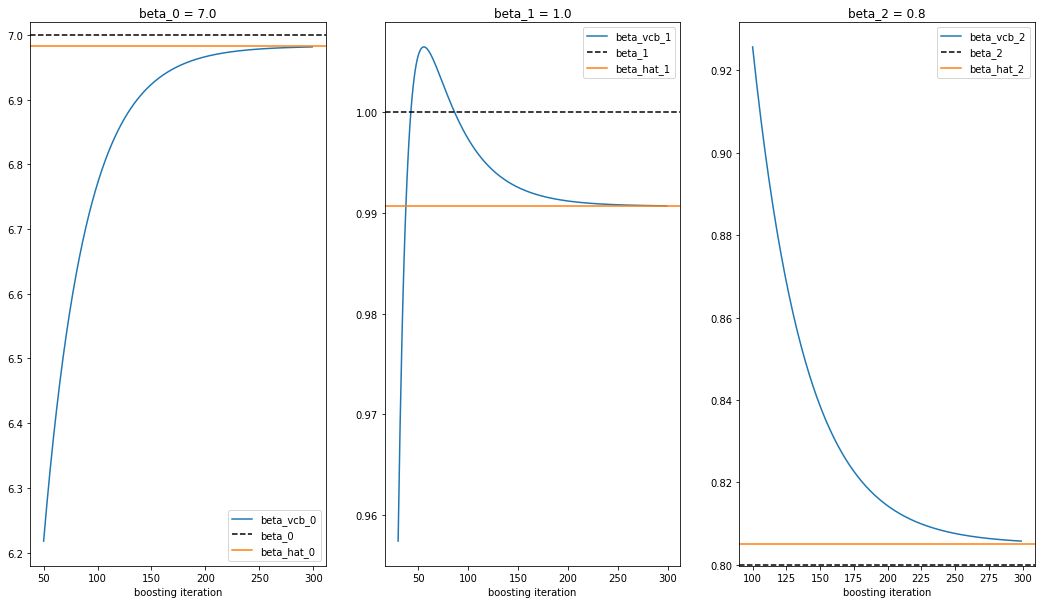

In [8]:
# fitted coefficients at each stage
beta_vcb = np.array(
    [vcb.predict_coefficients_at_stage(X=X_grid[[0]], Z=np.ones((1, 1)), stage=s).flatten() for s in range(vcb.n_stages)]
)

# visualize convergence of vcb estimates to usual least squares estimate for each coefficient
fig, ax = plt.subplots(1, 3, figsize=(18, 10))

# vcb coefficient estimates at different stages
ax[0].plot(range(50, vcb.n_stages), beta_vcb[50:,0], label='beta_vcb_0')
ax[1].plot(range(30, vcb.n_stages), beta_vcb[30:,1], label='beta_vcb_1')
ax[2].plot(range(100, vcb.n_stages), beta_vcb[100:,2], label='beta_vcb_2')

# add true coefficients and least squares estimates
for i in range(3):
    ax[i].axhline(beta[i], ls='--', c='k', label=f'beta_{i}')
    ax[i].axhline(beta_hat[i], c='C1', label=f'beta_hat_{i}')
    ax[i].set_title(f'beta_{i} = {beta[i]}')
    ax[i].legend()
    ax[i].set_xlabel('boosting iteration')